# Chatbot Integrated with Tools

Creating a Simple Chatbot where it takes the user prompt as an Input and provides the completion as an output using Graph API.

**StateGraph:**

"START" -> Node[Prompt passed to LLM] -> "END"

Here, we have
- 2 Edges (START to Node, Node to END)

- 1 Node (Prompt passed to LLM)
- State contains `messages` variable which gets appended everytime with the LLM response generated.

## Importing Environment Variables

In [7]:
from dotenv import load_dotenv
load_dotenv()

True

## Importing LangGraph Libraries

In [8]:
from typing import Annotated

from typing_extensions import TypedDict

# LangGraph 
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages # It is a Reducer, its main role is to append new messages to the variable which its defined.


## Initializing LLM 

In [9]:
from langchain_groq import ChatGroq # Type 1 Initialization 
from langchain.chat_models import init_chat_model # Type 2 Initialization - can be used with any chat model, not just Groq.

llm = ChatGroq(model="llama3-8b-8192")

llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x12cb89e20>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x12ccb9220>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

## Creating State 

In [10]:
class State(TypedDict):
    """
    Messages have the type "list". The `add_messages` function in the annotation
    defines how this state key should be updated. (In the current case, it appends messages to the list, rather than overwriting it.)
    """
    messages: Annotated[list, add_messages] # Annotated is used to add metadata to the type, in this case, it specifies that the `messages` list should be updated using the `add_messages` reducer. 

## Node Implementation for Chat Functionality

In [11]:
def chatBot(state: State): # Inheriting the State, since the state is passed to the function, it can be used to access and modify the state variables.
    return {"messages" : [llm.invoke(state["messages"])]}  # The function takes the current state, invokes the LLM with the messages, and returns the updated messages.

## Building Graph and adding Node and Edges

In [12]:
graph_builder = StateGraph(State)  # Create a StateGraph instance with the defined State type.

# Adding Node
graph_builder.add_node("llmchatbot", chatBot)  # Add the chatBot function as a node in the graph.

# Adding Edges
graph_builder.add_edge(START, "llmchatbot")  # Connect the START node to the llmchatbot node.
graph_builder.add_edge("llmchatbot", END)  # Connect the llmchatbot node to the END node.   

## Compiling the Graph

In [29]:
graph = graph_builder.compile()

## Visualizing the Graph

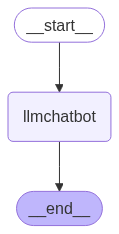

In [14]:
from IPython.display import Image, display

# Display the graph as an image
try: 
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Error displaying the graph:", e)

## Executing the Graph using `graph.invoke()`

In [15]:
response = graph.invoke(
    {
        "messages" : "Hello, I am Sai Kiran!"
    }
)

In [16]:
response

{'messages': [HumanMessage(content='Hello, I am Sai Kiran!', additional_kwargs={}, response_metadata={}, id='72c63685-07a5-4672-a6f1-e403ee378ab8'),
  AIMessage(content="Nice to meet you, Sai Kiran! It's great to have you here. How can I assist or chat with you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 18, 'total_tokens': 46, 'completion_time': 0.029516942, 'prompt_time': 0.004830941, 'queue_time': 0.270360258, 'total_time': 0.034347883}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--982a8d39-4243-4576-bb41-681d73211e5d-0', usage_metadata={'input_tokens': 18, 'output_tokens': 28, 'total_tokens': 46})]}

In the above output, we have received, if we remember correctly when creating the "State", we have mentioned `messages` as the list annotated with `add_messages` reducer. 

Here, the role of 
- `Annotated` is to convert the provided messages to either the Human or AI Message 

- `add_messages` reducer is making sure that the messages are getting appended to each other in a response. First the user input, next the LLM response. 

In [17]:
response["messages"][-1].content

"Nice to meet you, Sai Kiran! It's great to have you here. How can I assist or chat with you today?"

## Executing the Graph using `graph.stream()`

In [18]:
for event in graph.stream({ "messages" : "Hi, how are you doing?"}): 

    for value in event.values():
        print(value["messages"][-1].content)

I'm just a language model, I don't have emotions or feelings like humans do, so I don't have a good or bad day. I'm always "on" and ready to assist you with any questions or tasks you may have! It's great to chat with you, though! Is there something specific you'd like to talk about or ask?


---

## Integrating Tavily Search 

Tavily Search is just like Serper Tool in CrewAI, which does the google searches and provide the LLM with the recent or latest updates. 

In [19]:
from langchain_tavily import TavilySearch

tavily_search_tool = TavilySearch(max_results=2) # limiting the searches to 2 results for brevity

tavily_search_tool.invoke("What is the recent AI news today?")

{'query': 'What is the recent AI news today?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'AI News | Latest AI News, Analysis & Events',
   'url': 'https://www.artificialintelligence-news.com/',
   'content': 'AI News reports on the latest artificial intelligence news and insights. Explore industry trends from the frontline of AI.',
   'score': 0.63234437,
   'raw_content': None},
  {'title': 'AI News & Artificial Intelligence | TechCrunch',
   'url': 'https://techcrunch.com/category/artificial-intelligence/',
   'content': 'News coverage on artificial intelligence and machine learning tech, the companies building them, and the ethical issues AI raises today. This encompasses generative AI, including large language',
   'score': 0.58237284,
   'raw_content': None}],
 'response_time': 1.52}

## Creating Custom Tool/Function - `multiply()`

In [20]:
def multiply(a:int, b:int) -> int: 
    '''
    Multiply a and b 

    Args:
        a (int): first int
        b (int): second int 

    Returns: 
        int: output    
    
    '''
    return a * b 

## Adding Tools and Binding with LLM

**Binding** the LLM with tools, makes the LLM knows what tools are present for it to access. Each tool should have the docstrings attached if not necessary, as it helps the LLM know which tool need to be chosen during the query execution.

In [22]:
tools = [tavily_search_tool, multiply] # adding tools in the list 

llm_with_tools = llm.bind_tools(tools) # Binding the LLM with tools

In [23]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x12cb89e20>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x12ccb9220>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of domains to 

## Adding `tool_calling_llm` Node definition

In [25]:
def tool_calling_llm(state: State):

    return { "messages": [llm_with_tools.invoke(state["messages"])]} # We are using the LLM which was binded with tools.

## Creating StateGraph

In [38]:
# Importing required libraries
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(State) # using the same State class again which we have created earlier having messages attribute

# Adding Nodes
builder.add_node("tool_calling_llm", tool_calling_llm) # Adding the definition of the node
builder.add_node("tools", ToolNode(tools)) # Irrespective of number of tools, we can use the ToolNode function to add it as a single Node in the graph. 

# Adding Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm", 
    # If the latest message (result) from the assistant (LLM) node is a tool call -> tools_condition routes to tools node.
    # Tf the latest messsage (result) from the assistant (LLM) node is not a tool call -> tools_condition routes to END node.
    tools_condition
)
builder.add_edge("tools", END) # Adding the edge from tools node to END node.


Compiling the graph with all the edges and nodes defined

In [39]:
chatbot_with_tools_graph = builder.compile() # Compiling the graph

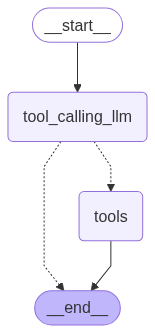

In [40]:
chatbot_with_tools_graph

## Testing the graph with queries

### Case 1: Making LLM to call the Tavily Search tool 

In [43]:
response = chatbot_with_tools_graph.invoke(
    {
        "messages" : "What are the recent news in AI?"
    }
)

# Printing the response from the LLM after invoking the graph with a message.
response

{'messages': [HumanMessage(content='What are the recent news in AI?', additional_kwargs={}, response_metadata={}, id='97ce63ec-580e-4370-bda4-3aea4dbff29a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'pc48by75v', 'function': {'arguments': '{"query":"What are the recent news in AI?","search_depth":"advanced","time_range":"week","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 97, 'prompt_tokens': 2196, 'total_tokens': 2293, 'completion_time': 0.149492767, 'prompt_time': 0.243900387, 'queue_time': 0.27290222700000005, 'total_time': 0.393393154}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8d5fcb58-02bf-486d-97a2-3cca4a4336ef-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'What are the recent news in AI?', 'search_depth': 'advanced', 'time_range': 'week', 'topic': 'news'}, 'id': 'pc48by75v', 'typ

In [48]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 54 multiplied by 23?
================================== Ai Message ==================================
Tool Calls:
  multiply (e44wcfh5b)
 Call ID: e44wcfh5b
  Args:
    a: 54
    b: 23
================================= Tool Message =================================
Name: multiply

1242


### Case 2: Making LLM to call the Multiply Function tool

In [53]:
response = chatbot_with_tools_graph.invoke(
    {
        "messages" : "What is 54 multiplied by 23 and then multipled by 10?"
    }
)

# Printing the response from the LLM after invoking the graph with a message.
response

{'messages': [HumanMessage(content='What is 54 multiplied by 23 and then multipled by 10?', additional_kwargs={}, response_metadata={}, id='d6a25799-9d7d-47b9-8a3a-cddd58dd2df1'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'k3tngdgag', 'function': {'arguments': '{"a":54,"b":23}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'ewc6rhkyx', 'function': {'arguments': '{"a":242,"b":10}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 125, 'prompt_tokens': 2204, 'total_tokens': 2329, 'completion_time': 0.190218571, 'prompt_time': 0.24482589, 'queue_time': 0.27379989400000004, 'total_time': 0.435044461}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2a782e8e-ae26-45c8-afe5-7bd94db7857f-0', tool_calls=[{'name': 'multiply', 'args': {'a': 54, 'b': 23}, 'id': 'k3tngdgag', 'type': 'tool_call'}, {'name': 'multiply', 'args': {'a': 242, 'b':

In [54]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 54 multiplied by 23 and then multipled by 10?
================================== Ai Message ==================================
Tool Calls:
  multiply (k3tngdgag)
 Call ID: k3tngdgag
  Args:
    a: 54
    b: 23
  multiply (ewc6rhkyx)
 Call ID: ewc6rhkyx
  Args:
    a: 242
    b: 10
================================= Tool Message =================================
Name: multiply

1242
================================= Tool Message =================================
Name: multiply

2420


### Case 3: Making LLM to call two tools at the same time - Tavily and Multiply tool

In [51]:
response = chatbot_with_tools_graph.invoke(
    {
        "messages" : "Tell me the recent news in AI and then multiply 10 and 2."
    }
)

# Printing the response from the LLM after invoking the graph with a message.
response

{'messages': [HumanMessage(content='Tell me the recent news in AI and then multiply 10 and 2.', additional_kwargs={}, response_metadata={}, id='8dfe49fa-b949-4553-96f2-24be7a471b93'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'xhq5q504a', 'function': {'arguments': '{"query":"recent AI news","search_depth":"advanced","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': 'j1bzkwx9c', 'function': {'arguments': '{"a":10,"b":2}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 184, 'prompt_tokens': 2204, 'total_tokens': 2388, 'completion_time': 0.202996133, 'prompt_time': 0.245820748, 'queue_time': 0.26864743, 'total_time': 0.448816881}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8086ef50-2957-46b4-8337-77167f839bd6-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'recent AI news', 'search_depth': 'adva

In [52]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Tell me the recent news in AI and then multiply 10 and 2.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (xhq5q504a)
 Call ID: xhq5q504a
  Args:
    query: recent AI news
    search_depth: advanced
    topic: news
  multiply (j1bzkwx9c)
 Call ID: j1bzkwx9c
  Args:
    a: 10
    b: 2
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.newsweek.com/nw-ai/ai-impact-awards-2025-science-engineering-2084754", "title": "AI Impact Awards 2025: The Changing Human Role in Science and Engineering - Newsweek", "score": 0.7251239, "published_date": "Wed, 25 Jun 2025 10:02:01 GMT", "content": "Newsweek _\\_will continue the conversation on meaningful AI innovations at our AI Impact Summit fr